# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот ноутбук является шаблоном (Baseline) к текущему соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **Baseline** создается больше как шаблон, где можно посмотреть, как происходит обращение с входящими данными и что нужно получить на выходе. При этом ML начинка может быть достаточно простой. Это помогает быстрее приступить к самому ML, а не тратить ценное время на инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если наше решение хуже baseline -  мы явно делаем что-то не так и стоит попробовать другой путь) 

## В baseline мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

from collections import Counter


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 1.9 MB/s 
     |████████████████████████████████| 8.2 MB 8.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 4.4 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import pymorphy2

In [6]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [7]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [8]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [9]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [10]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [12]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [13]:
# проверим наличие пустых ячеек
train.isnull().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
price                      0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                4326
ПТС                        0
Привод                     0
Руль                       0
dtype: int64

In [14]:
# много пропусков в столбце владение - лучше будет удалить его на следующем этапе

# проверим распределение по брендам в тесте и трейне
print(test['brand'].value_counts(normalize=True))
print(train['brand'].value_counts(normalize=True))

BMW         0.436864
MERCEDES    0.330341
AUDI        0.232795
Name: brand, dtype: float64
BMW         0.419784
MERCEDES    0.343310
AUDI        0.236905
Name: brand, dtype: float64


In [15]:
# распредение примерно одинаковое

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [16]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [17]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

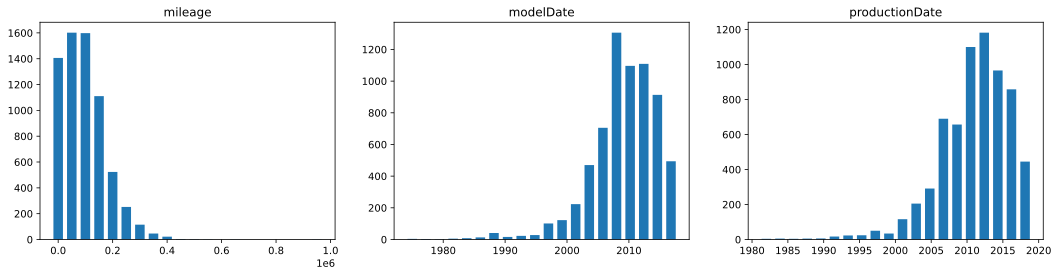

In [18]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

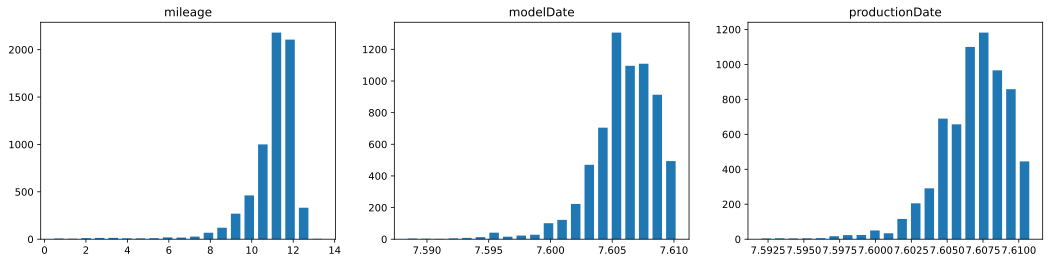

In [19]:
# попробуем логарифмировать признаки, у которых есть "хвосты"
visualize_distributions({
    'mileage': np.log(train['mileage']+1).dropna(),
    'modelDate': np.log(train['modelDate']+1).dropna(),
    'productionDate': np.log(train['productionDate']+1).dropna()
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [20]:
# посмотрим содержимое признака "Владение"
train['Владение']

0                      NaN
1        8 лет и 6 месяцев
2                      NaN
3       4 года и 9 месяцев
4       2 года и 9 месяцев
               ...        
6677                   NaN
6678     2 года и 2 месяца
6679     2 года и 2 месяца
6680                   NaN
6681                   NaN
Name: Владение, Length: 6682, dtype: object

In [21]:
# слишком много пропусков - нужно удалить

In [22]:
# обработаем признак 'vehicleConfiguration'
import nltk
nltk.download('punkt')
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words("english")

import string
print(string.punctuation)

spec_chars = string.punctuation + '«»—…’‘”“©'
print(spec_chars)

# Зададим функцию для удаления спец символов
def remove_chars_from_text(text, chars):
    return "".join([ch for ch in text if ch not in chars])

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~«»—…’‘”“©


In [23]:
english_stopwords_ = english_stopwords + ['лс','квт']
# Зададим функцию для токенизации
def text_tokenizer(text):
    Text_ = text.strip()

    Text_ = Text_.lower()

    # Удалим все спец символы
    Text_ = remove_chars_from_text(Text_, spec_chars)

    # Удалим все цифры
    Text_ = remove_chars_from_text(Text_, string.digits)

    Text_ = Text_.replace('\n',' ').replace('\t',' ')

    # Токенизируем текст
    tokens = word_tokenize(Text_)

    # Список токенов преобразовываем к классу Text
    token_text = nltk.Text(tokens)

    # Удаляем стоп-слова
    filtered_token_text = [w for w in token_text if not w in english_stopwords]
    
    return filtered_token_text

In [24]:
train['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))

0           [sedan, automatic]
1            [sedan, variator]
2           [sedan, automatic]
3            [sedan, variator]
4         [liftback, variator]
                 ...          
6677        [sedan, automatic]
6678        [sedan, automatic]
6679        [sedan, automatic]
6680        [sedan, automatic]
6681    [limousine, automatic]
Name: vehicleConfiguration, Length: 6682, dtype: object

# PreProc Tabular Data

In [25]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [26]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 'model_info', 'name',
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate']

In [27]:
#добавим функции для разбиения пробега и возраста авто по категориям
def mile_age(x):
    if x < 25000: x = 1
    elif 24999 < x < 50000: x = 2
    elif 49999 < x < 75000: x = 3
    elif 74999 < x < 100000: x = 4
    elif 99999 < x < 150000: x = 5
    elif 149999 < x < 200000: x = 6
    elif 199999 < x < 500000: x = 7
    elif 499999 < x: x = 8
    return x  

def product_age(x):
    if x > 2017: x = 1
    elif 2018 > x > 2015: x = 2
    elif 2016 > x > 2013: x = 3
    elif 2014 > x > 2004: x = 4
    elif 2005 > x: x = 5
    return x  

In [28]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 
                        'fuelType', 'model_info', 'numberOfDoors', 'vehicleTransmission', 
                        'Владельцы', 'ПТС', 'Привод', 'Руль', 'age_cat', 'mileage_category']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate', 'how_old',
                     'engineDisplacement_N','enginePower_N']

In [29]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'Владение'], axis = 1, inplace=True)
        
    # добавим признак сколько лет автомобилю    
    df_output['how_old'] = df_output['productionDate'].apply(lambda x: pd.Timestamp.today().year - x)
    
    # добавим признак mileage_per_year
#     df_output['mile_per_year'] = df_output['mileage'] / df_output['how_old']
    
    # добавим новые признаки
    df_output['age_cat'] = df_output['productionDate'].map(product_age)
    df_output['mileage_category'] = df_output['mileage'].map(mile_age)
    
    # ################### Numerical Features ############################################################## 
    
    # Сделаем числовой признка из engineDisplacement
    df_output['engineDisplacement_N'] = df_output['engineDisplacement'].apply(lambda x:
                                                                           x[:x.find(' LTR')])
    
    df_output['engineDisplacement_N'] = df_output['engineDisplacement_N'].apply(lambda x: float(x) if len(x)<4 else 0)
    
    # Сделаем числовой признка из enginePower
    df_output['enginePower_N'] = df_output['enginePower'].apply(lambda x: int(x[:x.find(' N12')]))
    
    # заполним и категоризируем столбец Владельцы
    c_1 = Counter(df_output['Владельцы'])
    df_output['Владельцы'].fillna(c_1.most_common()[0][0], inplace=True)
    df_output['Владельцы'] = df_output['Владельцы'].apply(lambda x: x[0])
    
    # обработаем признак "name"
    df_output['name'] = df_output['name'].apply(lambda x: text_tokenizer(x))
    
    name_dummies = df_output['name'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)
    
    # обработаем признак vehicleConfiguration
    df_output['vehicleConfiguration'] = df_output['vehicleConfiguration'].apply(lambda x: text_tokenizer(x))
    
    conf_dummies = df_output['vehicleConfiguration'].apply(lambda x: str(x).replace('[','').replace(']','')).str.get_dummies(sep=', ').reset_index(drop=True)
    
    
    df_output = pd.concat([df_output, name_dummies], axis=1)
    df_output = pd.concat([df_output, conf_dummies], axis=1)
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    
    # удаляем лишнее
    df_output.drop(['name','vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [30]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,modelDate,productionDate,sample,price,how_old,engineDisplacement_N,enginePower_N,'activehybrid','ah',...,age_cat_3,age_cat_4,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7
7399,0.106999,0.895833,0.868421,1,1590000.0,0.131579,0.303030,0.2720,0,0,...,0,0,0,0,0,0,1,0,0,0
4273,0.044999,0.875000,0.894737,1,3100000.0,0.105263,0.303030,0.2720,0,0,...,0,0,0,1,0,0,0,0,0,0
3362,0.054999,0.875000,0.868421,1,3750000.0,0.131579,0.833333,0.8160,0,0,...,0,0,0,0,1,0,0,0,0,0
2794,0.124999,0.833333,0.763158,1,1990000.0,0.236842,0.454545,0.2720,0,0,...,1,0,0,0,0,0,1,0,0,0
5378,0.148999,0.875000,0.868421,1,1285000.0,0.131579,0.303030,0.2288,0,0,...,0,0,0,0,0,0,1,0,0,0
5902,0.069799,0.854167,0.815789,1,3399999.0,0.184211,0.606061,0.7760,0,0,...,1,0,0,0,1,0,0,0,0,0
1454,0.052765,0.854167,0.868421,0,0.0,0.131579,0.454545,0.3920,0,0,...,0,0,0,0,1,0,0,0,0,0
2476,0.173499,0.750000,0.684211,1,700000.0,0.315789,0.378788,0.2288,0,0,...,1,0,0,0,0,0,0,1,0,0
743,0.119999,0.750000,0.736842,0,0.0,0.263158,0.242424,0.0640,0,0,...,1,0,0,0,0,0,1,0,0,0
1168,0.035999,0.854167,0.842105,0,0.0,0.157895,0.833333,0.7504,0,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 481 entries, mileage to mileage_category_7
dtypes: float64(7), int64(79), uint8(395)
memory usage: 8.6 MB


## Split data

In [32]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # логарифмируем наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 480 entries, mileage to mileage_category_7
dtypes: float64(7), int64(78), uint8(395)
memory usage: 1.7 MB


# Model 2: CatBoostRegressor

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [35]:
model = CatBoostRegressor(iterations = 5000,
                          #depth=10,
                          learning_rate = 0.1,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0392641	test: 0.0392671	best: 0.0392671 (0)	total: 55.5ms	remaining: 4m 37s
100:	learn: 0.0094417	test: 0.0093265	best: 0.0093265 (100)	total: 468ms	remaining: 22.7s
200:	learn: 0.0081569	test: 0.0085084	best: 0.0085084 (200)	total: 883ms	remaining: 21.1s
300:	learn: 0.0075380	test: 0.0081934	best: 0.0081934 (300)	total: 1.32s	remaining: 20.6s
400:	learn: 0.0071145	test: 0.0080414	best: 0.0080414 (400)	total: 1.74s	remaining: 19.9s
500:	learn: 0.0067686	test: 0.0079624	best: 0.0079589 (493)	total: 2.17s	remaining: 19.5s
600:	learn: 0.0064885	test: 0.0079236	best: 0.0079215 (597)	total: 2.58s	remaining: 18.9s
700:	learn: 0.0062430	test: 0.0078766	best: 0.0078748 (692)	total: 2.95s	remaining: 18.1s
800:	learn: 0.0060309	test: 0.0078660	best: 0.0078630 (785)	total: 3.69s	remaining: 19.3s
900:	learn: 0.0058517	test: 0.0078568	best: 0.0078466 (880)	total: 4.13s	remaining: 18.8s
1000:	learn: 0.0056686	test: 0.0078471	best: 0.0078466 (880)	total: 4.51s	remaining: 18s
1100:	learn: 

In [36]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, np.exp(test_predict_catboost)))*100:0.2f}%")

TEST mape: 11.38%


### Submission

In [37]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [38]:
X_train.head(5)

,mileage,modelDate,productionDate,how_old,engineDisplacement_N,enginePower_N,'activehybrid','ah','allterrain','amg',...,age_cat_3,age_cat_4,mileage_category_0,mileage_category_1,mileage_category_2,mileage_category_3,mileage_category_4,mileage_category_5,mileage_category_6,mileage_category_7
7320,0.149999,0.770833,0.763158,0.236842,0.909091,0.7504,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
8037,0.020941,0.937500,0.947368,0.052632,0.303030,0.2720,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4681,0.133896,0.687500,0.631579,0.368421,0.469697,0.2880,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
6014,0.329999,0.729167,0.657895,0.342105,0.272727,0.1744,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3649,0.125999,0.833333,0.815789,0.184211,0.454545,0.3808,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


## Simple Dense NN

In [39]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [40]:
model = Sequential([
    L.Dense(1024, activation='relu', input_dim=X_train.shape[1]),
    L.Dropout(0.5),
    L.BatchNormalization(),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.BatchNormalization(),
    L.Dense(1, activation="linear"),
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              491520    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [42]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.1)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [43]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [44]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=0,
                   )

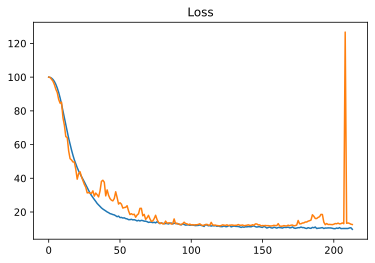

In [45]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [46]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [47]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 12.57%


In [48]:
sub_predict_nn1 = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


Рекомендации для улучшения Model 3:    
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'), поэтому эти данные можно удалить. Затем следует еще сильнее сократить размерность, например, выделив наличие xDrive в качестве отдельного признака.

# Model 4: NLP + Multiple Inputs

In [49]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [50]:
#проведем лемматизацию
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [51]:
data['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [52]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [53]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [54]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.36 s, sys: 8.76 ms, total: 1.37 s
Wall time: 1.37 s


In [55]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'автомобиль': 6,
 'не': 7,
 'по': 8,
 'система': 9,
 'задний': 10,
 'всё': 11,
 'пробег': 12,
 'салон': 13,
 'сидение': 14,
 'для': 15,
 'передний': 16,
 'от': 17,
 'машина': 18,
 'до': 19,
 'у': 20,
 '2': 21,
 'комплект': 22,
 'при': 23,
 'год': 24,
 'официальный': 25,
 'без': 26,
 'ваш': 27,
 'кредит': 28,
 'вы': 29,
 'диск': 30,
 'новый': 31,
 'авто': 32,
 'состояние': 33,
 'пакет': 34,
 'фара': 35,
 'безопасность': 36,
 'руль': 37,
 'за': 38,
 'колесо': 39,
 'дилер': 40,
 'гарантия': 41,
 'состоянии': 42,
 'птс': 43,
 'обмен': 44,
 'контроль': 45,
 'то': 46,
 'комплектация': 47,
 'bmw': 48,
 'быть': 49,
 '000': 50,
 'из': 51,
 'два': 52,
 'более': 53,
 'полный': 54,
 'весь': 55,
 'покупка': 56,
 'зеркало': 57,
 'датчик': 58,
 '1': 59,
 'есть': 60,
 'только': 61,
 'мы': 62,
 'продажа': 63,
 'отличный': 64,
 'автомобиля': 65,
 'один': 66,
 'водитель': 67,
 'подушка': 68,
 'шина': 69,
 'пассажир': 70,
 '6': 71,
 'двигатель': 72,
 'хороший

In [56]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.38 s, sys: 10 ms, total: 1.39 s
Wall time: 1.39 s


In [57]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

. • автомобиль проверить по 110 пункт • автокредит по специальный ставка от 13,7% ауди центр север, официальный дилер audi, входящий в группа компания рольф и являться один из крупный дилер в европе, предлагать вы ряд услуга по покупка и продажа автомобиль с пробегом. на протяжение многий год наш дилерский центр являться лидер по продажа автомобиль с пробег среди весь дилер audi в россия и предоставлять клиент самый большой выбор автомобиль с пробег audi и другой марок. каждый автомобиль проходить тщательный диагностик и подготовку, и гарантировать находиться в отличный состоянии. чтобы убедиться в правильный выборе, у вы есть возможность пройти тест-драйв ― ознакомительный поездка на интересовать автомобиле. вы смочь ознакомиться с автомобиль не выходить из дом – наш менеджер провести online презентация и в видеозвонок показать выбрать автомобиль. также ауди центр север представлять уникальный предложение по кредитование автомобиль с пробег на индивидуальный условиях. специалист компа

### RNN NLP

In [58]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [59]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [60]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [61]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     8131328     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [62]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [63]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint,earlystop] 

In [64]:
history = model.fit([text_train_sequences, X_train], (y_train),
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], (y_test)),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 4s 355ms/step - loss: 99.9802 - MAPE: 99.9802 - val_loss: 99.7564 - val_MAPE: 99.7564
Epoch 2/500
12/12 [==============================] - 3s 274ms/step - loss: 97.7817 - MAPE: 97.7817 - val_loss: 90.0935 - val_MAPE: 90.0935
Epoch 3/500
12/12 [==============================] - 3s 268ms/step - loss: 70.8048 - MAPE: 70.8048 - val_loss: 49.5617 - val_MAPE: 49.5617
Epoch 4/500
12/12 [==============================] - 3s 283ms/step - loss: 49.8592 - MAPE: 49.8592 - val_loss: 44.2410 - val_MAPE: 44.2410
Epoch 5/500
12/12 [==============================] - 3s 272ms/step - loss: 43.4873 - MAPE: 43.4873 - val_loss: 38.7066 - val_MAPE: 38.7066
Epoch 6/500
12/12 [==============================] - 3s 280ms/step - loss: 37.5603 - MAPE: 37.5603 - val_loss: 34.3777 - val_MAPE: 34.3777
Epoch 7/500
12/12 [==============================] - 4s 299ms/step - loss: 33.4086 - MAPE: 33.4086 - val_loss: 29.3318 - val_MAPE: 29.3318
Epoch 8/500
12/12 [========

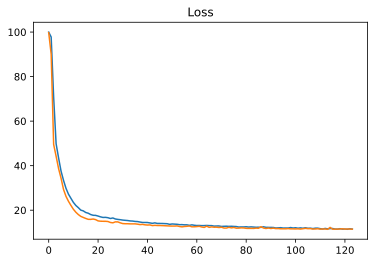

In [65]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [66]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [67]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.48%


In [68]:
sub_predict_nn2 = (model.predict([text_sub_sequences, X_sub]))
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

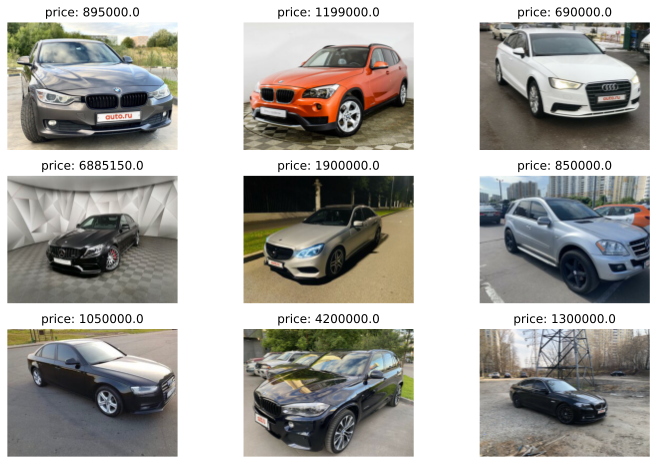

In [69]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [70]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

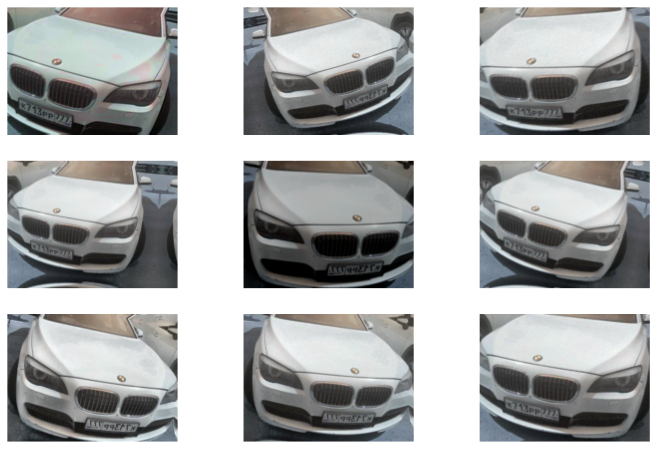

In [71]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [72]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [73]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [74]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [75]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

43941888/43941136 [==============================] - 0s 0us/step


In [76]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [77]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [78]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [79]:
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [80]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint,earlystop] 

In [81]:
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 133s 701ms/step - loss: 77.5334 - MAPE: 77.5334 - val_loss: 44.1337 - val_MAPE: 44.1337
Epoch 2/100
190/190 [==============================] - 129s 679ms/step - loss: 39.9563 - MAPE: 39.9563 - val_loss: 33.5362 - val_MAPE: 33.5362
Epoch 3/100
190/190 [==============================] - 129s 681ms/step - loss: 31.0303 - MAPE: 31.0303 - val_loss: 26.1105 - val_MAPE: 26.1105
Epoch 4/100
190/190 [==============================] - 129s 678ms/step - loss: 26.1887 - MAPE: 26.1887 - val_loss: 22.7464 - val_MAPE: 22.7464
Epoch 5/100
190/190 [==============================] - 129s 680ms/step - loss: 23.7032 - MAPE: 23.7032 - val_loss: 20.3432 - val_MAPE: 20.3432
Epoch 6/100
190/190 [==============================] - 129s 681ms/step - loss: 22.0043 - MAPE: 22.0043 - val_loss: 18.8766 - val_MAPE: 18.8766
Epoch 7/100
190/190 [==============================] - 129s 681ms/step - loss: 20.7262 - MAPE: 20.7262 - val_loss: 17.6022 - val_MAPE: 17.6022

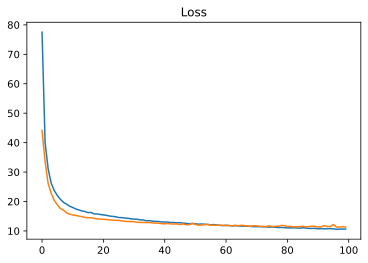

In [82]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [83]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [84]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.33%


In [85]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Общие рекомендации:
* Попробовать разные архитектуры
* Провести более детальный анализ результатов
* Попробовать различные подходы в управление LR и оптимизаторы
* Поработать с таргетом
* Использовать Fine-tuning

#### Tabular
* В нейросеть желательно подавать данные с распределением, близким к нормальному, поэтому от некоторых числовых признаков имеет смысл взять логарифм перед нормализацией. Пример:
`modelDateNorm = np.log(2020 - data['modelDate'])`
Статья по теме: https://habr.com/ru/company/ods/blog/325422

* Извлечение числовых значений из текста:
Парсинг признаков 'engineDisplacement', 'enginePower', 'Владение' для извлечения числовых значений.

* Cокращение размерности категориальных признаков
Признак name 'name' содержит данные, которые уже есть в других столбцах ('enginePower', 'engineDisplacement', 'vehicleTransmission'). Можно удалить эти данные. Затем можно еще сильнее сократить размерность, например выделив наличие xDrive в качестве отдельного признака.

* Поработать над Feature engineering



#### NLP
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста



#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [86]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.69%


In [87]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn1[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.15%


In [88]:
blend_predict = (np.exp(test_predict_catboost) + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 10.66%


In [89]:
blend_predict = (test_predict_nn1[:,0] + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.67%


In [90]:
blend_predict = (test_predict_nn1[:,0] + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.65%


In [91]:
blend_predict = (test_predict_nn2[:,0] + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.29%


In [92]:
blend_sub_predict = (np.exp(sub_predict_catboost) + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_cat_nn3.csv', index=False)

In [93]:
blend_sub_predict = (np.exp(sub_predict_catboost) + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_cat_nn2.csv', index=False)

In [94]:
blend_sub_predict = (np.exp(sub_predict_catboost) + sub_predict_nn1[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_cat_nn1.csv', index=False)

In [95]:
blend_sub_predict = (sub_predict_nn1[:,0] + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_nn1_nn2.csv', index=False)

In [96]:
blend_sub_predict = (sub_predict_nn1[:,0] + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_nn1_nn3.csv', index=False)

In [97]:
blend_sub_predict = (sub_predict_nn2[:,0] + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission_nn2_nn3.csv', index=False)

# Model Bonus: проброс признака

In [98]:
# # MLP
# model_mlp = Sequential()
# model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
# model_mlp.add(L.Dropout(0.5))
# model_mlp.add(L.Dense(256, activation="relu"))
# model_mlp.add(L.Dropout(0.5))

In [99]:
# # FEATURE Input
# # Iput
# productiondate = L.Input(shape=[1], name="productiondate")
# # Embeddings layers
# emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
# f_productiondate = L.Flatten()(emb_productiondate)

In [100]:
# combinedInput = L.concatenate([model_mlp.output, f_productiondate,])
# # being our regression head
# head = L.Dense(64, activation="relu")(combinedInput)
# head = L.Dense(1, activation="linear")(head)

# model = Model(inputs=[model_mlp.input, productiondate], outputs=head)

In [101]:
# model.summary()

In [102]:
# optimizer = tf.keras.optimizers.Adam(0.01)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [103]:
# history = model.fit([X_train, X_train.productionDate.values], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([X_test, X_test.productionDate.values], y_test),
#                     callbacks=callbacks_list
#                    )

In [104]:
# model.load_weights('../working/best_model.hdf5')
# test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
# print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

In [105]:
# 